In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Download necessary resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\viren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\viren\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Load the dataset
df = pd.read_csv('R:/IIT_MADRAS_DATA_SCINCE/DataSet/Healthcare Reviews/healthcare_reviews.csv')

In [3]:
df.head()

,Review_Text,Rating
0,I have mixed feelings about my experience.,4
1,The staff was caring and attentive. I couldn't...,5
2,I have mixed feelings about my experience.,5
3,I have mixed feelings about my experience.,5
4,The healthcare provider was excellent. I had a...,3


In [4]:
df.isnull().sum()

Review_Text    100
Rating           0
dtype: int64

In [5]:
df = df.dropna()
df.shape

(900, 2)

In [6]:
df

,Review_Text,Rating
0,I have mixed feelings about my experience.,4
1,The staff was caring and attentive. I couldn't...,5
2,I have mixed feelings about my experience.,5
3,I have mixed feelings about my experience.,5
4,The healthcare provider was excellent. I had a...,3
...,...,...
995,My experience was terrible. I would not recomm...,5
996,The service was disappointing. I won't be comi...,4
997,"The service was okay, but nothing exceptional.",3
998,I have mixed feelings about my experience.,5


# 1. Data Preprocessing

In [7]:
# Preprocessing function
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing
df['cleaned_review'] = df['Review_Text'].apply(preprocess_text)

# Display sample cleaned data
df[['Review_Text', 'cleaned_review']].head()

,Review_Text,cleaned_review
0,I have mixed feelings about my experience.,mixed feeling experience
1,The staff was caring and attentive. I couldn't...,staff caring attentive couldnt happier
2,I have mixed feelings about my experience.,mixed feeling experience
3,I have mixed feelings about my experience.,mixed feeling experience
4,The healthcare provider was excellent. I had a...,healthcare provider excellent great experience


In [8]:
df.loc[df['Rating'] > 3, 'Sentiment'] = '1'
df.loc[df['Rating'] == 3, 'Sentiment'] = '0'
df.loc[df['Rating'] < 3, 'Sentiment'] = '-1'

In [9]:
class_counts = df['Sentiment'].value_counts()
print(class_counts)

Sentiment
1     388
-1    365
0     147
Name: count, dtype: int64


In [10]:
df

,Review_Text,Rating,cleaned_review,Sentiment
0,I have mixed feelings about my experience.,4,mixed feeling experience,1
1,The staff was caring and attentive. I couldn't...,5,staff caring attentive couldnt happier,1
2,I have mixed feelings about my experience.,5,mixed feeling experience,1
3,I have mixed feelings about my experience.,5,mixed feeling experience,1
4,The healthcare provider was excellent. I had a...,3,healthcare provider excellent great experience,0
...,...,...,...,...
995,My experience was terrible. I would not recomm...,5,experience terrible would recommend provider,1
996,The service was disappointing. I won't be comi...,4,service disappointing wont coming back,1
997,"The service was okay, but nothing exceptional.",3,service okay nothing exceptional,0
998,I have mixed feelings about my experience.,5,mixed feeling experience,1


# Handle Imbalanced Data

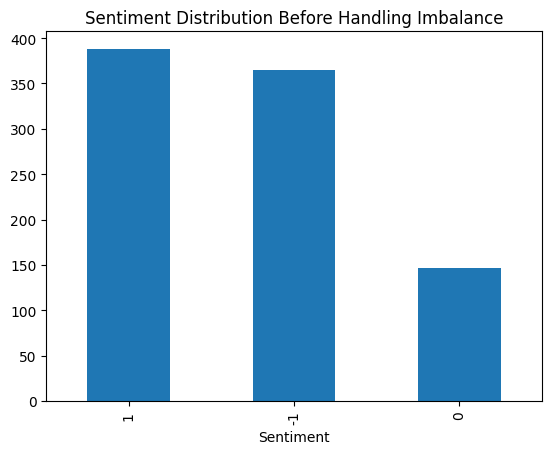

Counter({'0': 312, '-1': 312, '1': 312})


In [11]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Check original sentiment distribution
df['Sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution Before Handling Imbalance')
plt.show()

# Split features and labels
X = df['cleaned_review']
y = df['Sentiment']

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Apply SMOTE to handle imbalanced data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the new class distribution
from collections import Counter
print(Counter(y_train_smote))


# handel imbalanced data

In [12]:
# Total samples
total_samples = 388 + 365 + 147  # Sum of all instances

# Calculate class weights
class_weights = {
    1: total_samples / (3 * 388),   # Positive sentiment
    -1: total_samples / (3 * 365),  # Negative sentiment
    0: total_samples / (3 * 147)    # Neutral sentiment
}

print(class_weights)

{1: 0.7731958762886598, -1: 0.821917808219178, 0: 2.0408163265306123}


In [13]:
print(class_weights)

{1: 0.7731958762886598, -1: 0.821917808219178, 0: 2.0408163265306123}


In [14]:
print("Shape of X_tfidf:", X_tfidf.shape)
print("Length of y_train:", len(y_train))

Shape of X_tfidf: (900, 34)
Length of y_train: 720


# Model Building

 Random Forest Classifier

Random Forest Classification Report:
              precision    recall  f1-score   support

          -1       0.41      0.52      0.46        79
           0       0.12      0.20      0.15        25
           1       0.39      0.18      0.25        76

    accuracy                           0.33       180
   macro avg       0.30      0.30      0.28       180
weighted avg       0.36      0.33      0.33       180



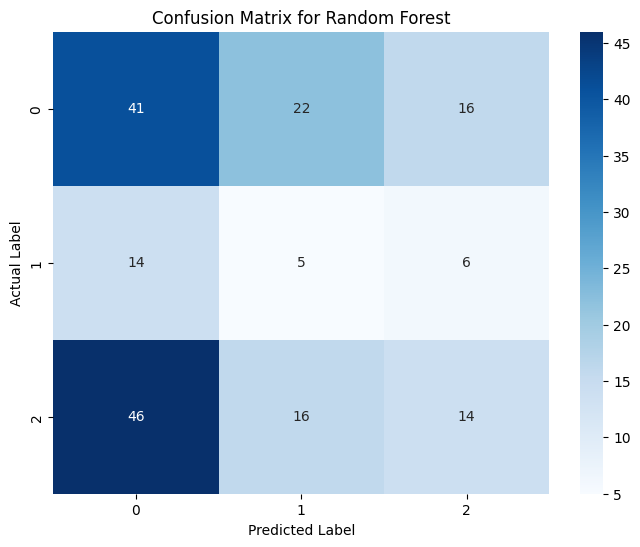

Random Forest Accuracy: 0.3333333333333333


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Random Forest')
plt.show()

# Check the accuracy score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

Naive Bayes Classifier

Naive Bayes Classification Report:
              precision    recall  f1-score   support

          -1       0.42      0.41      0.41        79
           0       0.12      0.20      0.15        25
           1       0.39      0.32      0.35        76

    accuracy                           0.34       180
   macro avg       0.31      0.31      0.30       180
weighted avg       0.37      0.34      0.35       180



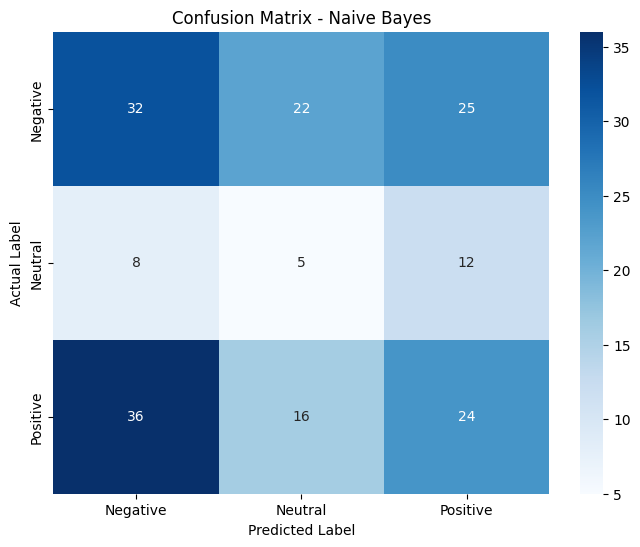

Naive Bayes Accuracy: 33.89%


In [21]:
from sklearn.naive_bayes import MultinomialNB

# Initialize Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_nb = nb_model.predict(X_test)

# Evaluate the model
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

# Confusion Matrix
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

print(f'Naive Bayes Accuracy: {nb_accuracy * 100:.2f}%')

Support Vector Machine (SVM)

SVM Classification Report:
              precision    recall  f1-score   support

          -1       0.41      0.52      0.46        79
           0       0.12      0.20      0.15        25
           1       0.39      0.18      0.25        76

    accuracy                           0.33       180
   macro avg       0.30      0.30      0.28       180
weighted avg       0.36      0.33      0.33       180



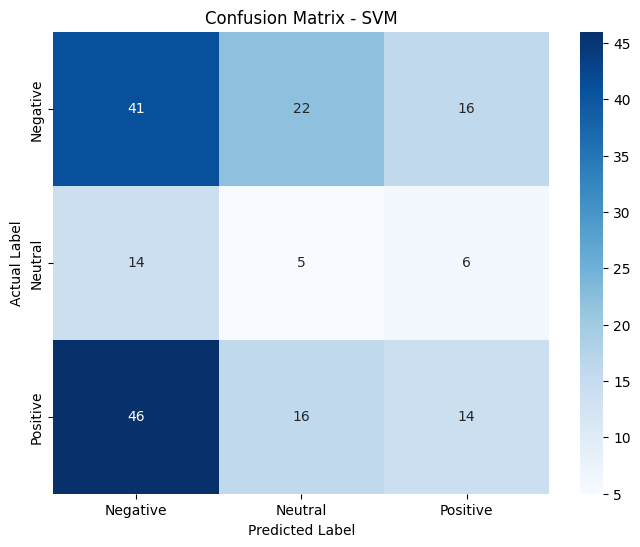

SVM Accuracy: 33.33%


In [22]:
from sklearn.svm import SVC

# Initialize SVM model
svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - SVM')
plt.show()

print(f'SVM Accuracy: {svm_accuracy * 100:.2f}%')

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the Logistic Regression model with class_weight='balanced'
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.41      0.52      0.46        79
           0       0.12      0.20      0.15        25
           1       0.39      0.18      0.25        76

    accuracy                           0.33       180
   macro avg       0.30      0.30      0.28       180
weighted avg       0.36      0.33      0.33       180



# Analysis the test data:

In [17]:
# Create a DataFrame using the test set (X_test)
analysis_df = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out())

# Add the actual sentiment labels (y_test) and predicted sentiment labels (y_pred)
analysis_df['y_test'] = y_test.values
analysis_df['y_pred'] = y_pred

# Save the analysis results to a CSV file
analysis_df.to_csv(r"C:\Users\viren\OneDrive\Desktop\IIT-MADARAS(GUVI)\Sentiment Analysis HealthCare\NLP-Sentiment-Analysis-on-Healthcare-Reviews\analysis.csv", index=False)

print("Analysis results saved to analysis.csv")


Analysis results saved to analysis.csv


# Model Evaluation

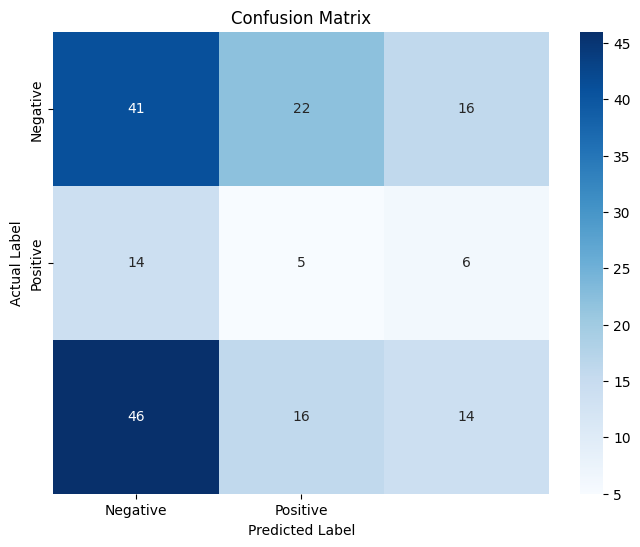

Classification Report:
              precision    recall  f1-score   support

          -1       0.41      0.52      0.46        79
           0       0.12      0.20      0.15        25
           1       0.39      0.18      0.25        76

    accuracy                           0.33       180
   macro avg       0.30      0.30      0.28       180
weighted avg       0.36      0.33      0.33       180



In [16]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


# Sentiment Distribution

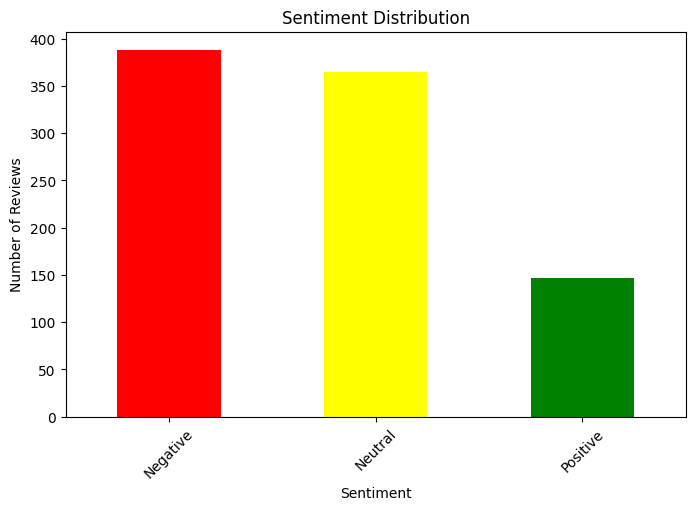

In [17]:
# Sentiment distribution
sentiment_counts = df['Sentiment'].value_counts()
sentiment_counts.index = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(8,5))
sentiment_counts.plot(kind='bar', color=['red', 'yellow', 'green'])
plt.title('Sentiment Distribution')
plt.ylabel('Number of Reviews')
plt.xlabel('Sentiment')
plt.xticks(rotation=45)
plt.show()

# Visualization of Results

Unique Sentiment Values: [1 0 -1]


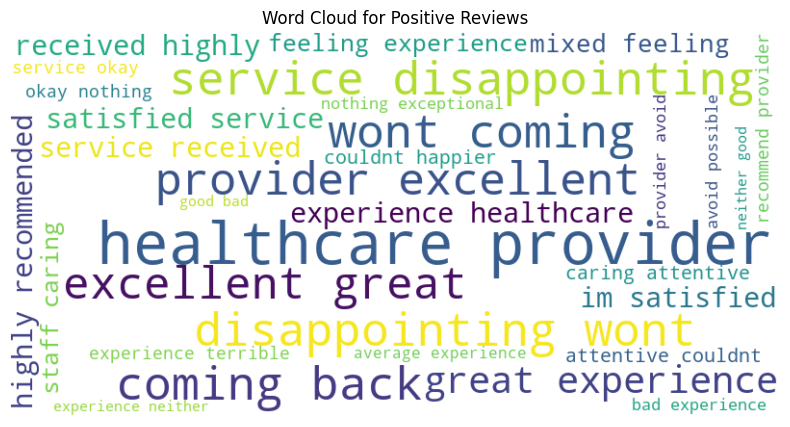

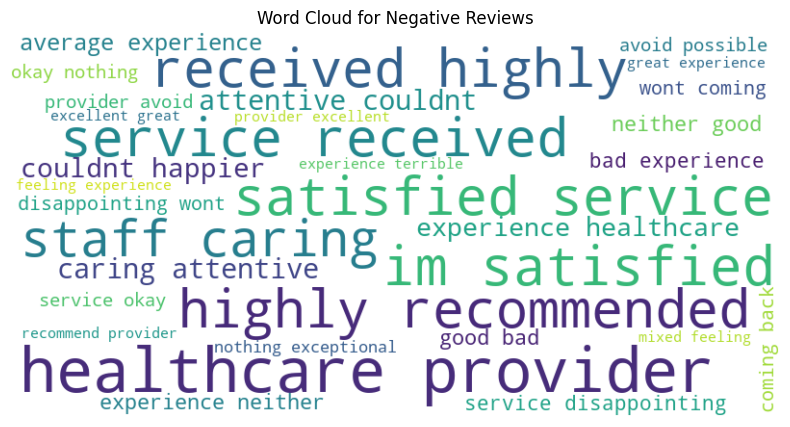

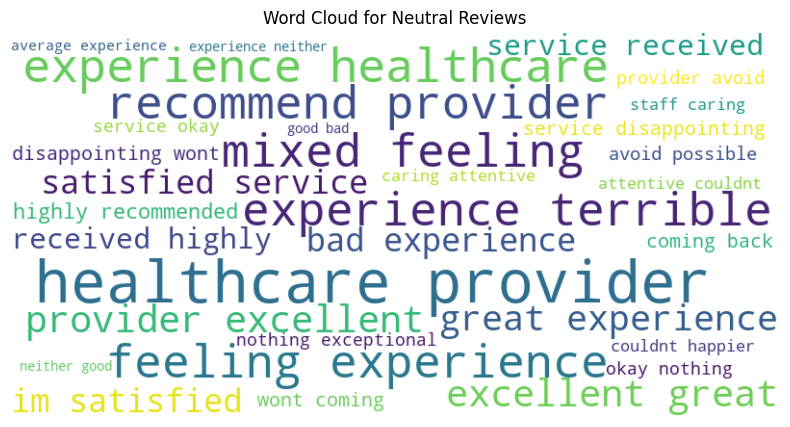

In [18]:
from wordcloud import WordCloud


# Ensure the sentiment mapping is correct
df.loc[df['Rating'] > 3, 'Sentiment'] = 1
df.loc[df['Rating'] == 3, 'Sentiment'] = 0
df.loc[df['Rating'] < 3, 'Sentiment'] = -1

# Check the unique values in the Sentiment column
print("Unique Sentiment Values:", df['Sentiment'].unique())

# Join positive and negative reviews
positive_reviews = ' '.join(df[df['Sentiment'] == 1]['cleaned_review'])
negative_reviews = ' '.join(df[df['Sentiment'] == -1]['cleaned_review'])
neutral_reviews = ' '.join(df[df['Sentiment'] == 0]['cleaned_review'])

# Check if there are reviews to generate word clouds
if positive_reviews:
    # Word Cloud for Positive Sentiments
    wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_pos, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Positive Reviews')
    plt.show()


if negative_reviews:
    # Word Cloud for Negative Sentiments
    wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_neg, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Negative Reviews')
    plt.show()


if neutral_reviews:
    # Word Cloud for Neutral Sentiments
    wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_reviews)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_neutral, interpolation='bilinear')

    plt.axis('off')
    plt.title('Word Cloud for Neutral Reviews')
    plt.show()

